In [2]:
!mkdir -p /root/.kaggle
!cp /kaggle/input/jsonkaggle/kaggle.json /root/.kaggle/
# !cp /kaggle/input/kaggle.json /root/.kaggle/

In [3]:
import kaggle
kaggle.api.authenticate()

In [4]:
# kaggle.api.competition_download_files('CIFAR-10 - Object Recognition in Images')
!kaggle competitions download -c cifar-10

 99%|████████████████████████████████████████▍| 706M/715M [00:06<00:00, 175MB/s]
100%|█████████████████████████████████████████| 715M/715M [00:06<00:00, 114MB/s]


In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!unzip -q cifar-10.zip

In [7]:
# !apt-get install p7zip-full
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 26.7 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 13.4 MB/s eta 0:00:00


In [8]:
# !7z x train.7z
# !7z x test.7z

import py7zr

archive = py7zr.SevenZipFile('train.7z', mode='r')
archive.extractall() #archive.extractall(path='')
archive.close()

archive = py7zr.SevenZipFile('test.7z', mode='r')
archive.extractall() #archive.extractall(path='')
# archive1.close()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

In [10]:
# Load the data
train_df = pd.read_csv('trainLabels.csv')
train_labels = train_df['label'].values
train_path = 'train/'
test_path = 'test/'

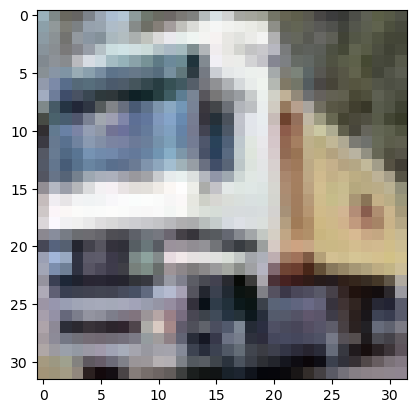

In [12]:
from PIL import Image

# Load the first image from the training set
# img = Image.open(train_path + train_df['id'][0] + '.png')
img = Image.open(train_path + str(train_df['id'][1]) + '.png')

# Display the image
plt.imshow(img)
plt.show()

In [13]:
from keras.applications import ResNet50V2
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Load the ResNet50V2 model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Add custom layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Freeze the weights of the base model
base_model.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94668760/94668760 [==============================] - 2s 0us/step


In [14]:
from keras.preprocessing.image import ImageDataGenerator
import os

In [16]:
test_path = 'test/'

# Get the filenames of the test images
test_filenames = os.listdir(test_path)
print(test_filenames[:10])

['280946.png', '42185.png', '59124.png', '23883.png', '1554.png', '185898.png', '288162.png', '200857.png', '289909.png', '199604.png']


In [17]:
# Create a DataFrame with the filenames
test_df = pd.DataFrame({
    'id': test_filenames
})

test_df.head()
# train_df.head()

,id
0,280946.png
1,42185.png
2,59124.png
3,23883.png
4,1554.png


In [18]:
train_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [19]:
test_df['id'] = test_df['id'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Creating test generator")
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test/',
    x_col='id',
    y_col=None,
    target_size=(32, 32),
    batch_size=32,
    class_mode=None)

Creating test generator
Found 300000 validated image filenames.


In [20]:
train_df['id'] = train_df['id'].astype(str) + '.png'
# tr(train_df['id'][1]) + '.png'
train_df.head()


,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


In [21]:
# Create data generators for the training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)


In [22]:
print("Creating train generator")

# Create the train generator again with the updated DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train/',
    x_col='id',
    y_col='label',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

Creating train generator
Found 50000 validated image filenames belonging to 10 classes.


In [23]:

# Train the model
print("Training the model")
model.fit(train_generator, epochs=10, validation_data=test_generator)

Training the model
Epoch 1/10
1563/1563 [==============================] - 171s 104ms/step - loss: 1.9248 - accuracy: 0.3165 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
1563/1563 [==============================] - 152s 97ms/step - loss: 1.7991 - accuracy: 0.3609 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
1563/1563 [==============================] - 146s 93ms/step - loss: 1.7480 - accuracy: 0.3777 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
1563/1563 [==============================] - 146s 94ms/step - loss: 1.7119 - accuracy: 0.3916 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
1563/1563 [==============================] - 147s 94ms/step - loss: 1.6893 - accuracy: 0.3999 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
1563/1563 [==============================] - 144s 92ms/step - loss: 1.6679 - accuracy: 0.4093 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
1563/1563 [============================

In [26]:
preds = model.predict(test_generator, verbose=1)

9375/9375 [==============================] - 332s 35ms/step


In [28]:
pd.read_csv('sampleSubmission.csv')

,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat
...,...,...
299995,299996,cat
299996,299997,cat
299997,299998,cat
299998,299999,cat


In [29]:
class_names = {0: 'frog', 1: 'truck', 2: 'deer', 3: 'automobile', 4: 'bird', 5: 'horse', 6: 'ship', 7: 'cat', 8: 'dog', 9: 'airplane'}

# Convert predictions to class labels
pred_labels = np.argmax(preds, axis=1)
pred_class_names = [class_names[label] for label in pred_labels]

# Create submission file
with open('submission1.csv', 'w') as f:
    f.write('id,label\n')
    for i, filename in enumerate(test_filenames):
        f.write(f'{i},{pred_class_names[i]}\n')

In [30]:
pd.read_csv('submission1.csv')

,id,label
0,0,dog
1,1,frog
2,2,bird
3,3,bird
4,4,deer
...,...,...
299995,299995,airplane
299996,299996,horse
299997,299997,truck
299998,299998,automobile


In [31]:
model.evaluate(test_generator)

9375/9375 [==============================] - 306s 33ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [34]:
model.layers[0].input_shape

(None, 32, 32, 3)

In [43]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

img_path = '/kaggle/input/dfggyyys/100011.png'
img = image.load_img(img_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # assuming you're using a pre-trained model

print(x.shape)

(1, 32, 32, 3)


In [44]:
# Make prediction
pred = model.predict(x)[0]
pred_label = class_names[np.argmax(pred)]

print('Prediction:', pred_label)

1/1 [==============================] - 0s 31ms/step
Prediction: truck


In [45]:
predict_csv_df = pd.read_csv('/kaggle/working/submission1.csv')
predict_csv_df.head()

,id,label
0,0,dog
1,1,frog
2,2,bird
3,3,bird
4,4,deer


In [46]:
predict_csv_df['label'].value_counts()

bird          49497
ship          41812
dog           34965
airplane      31251
frog          26601
automobile    25852
deer          23926
cat           23886
horse         22717
truck         19493
Name: label, dtype: int64

In [47]:
predict_csv_df.shape

(300000, 2)